In [1]:
from google.colab import files
uploaded = files.upload()

Saving Tweets.csv to Tweets.csv


In [2]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('Tweets.csv')
# Preview the dataset
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
import string
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

nltk.download('punkt')
nltk.download('stopwords')

# Define preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return " ".join(tokens)

# Apply preprocessing to the text column
df['clean_text'] = df['text'].apply(preprocess_text)

# Preview the cleaned text
df[['text', 'clean_text']].head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,text,clean_text
0,@VirginAmerica What @dhepburn said.,virginamerica dhepburn said
1,@VirginAmerica plus you've added commercials t...,virginamerica plus youve added commercials exp...
2,@VirginAmerica I didn't today... Must mean I n...,virginamerica didnt today must mean need take ...
3,@VirginAmerica it's really aggressive to blast...,virginamerica really aggressive blast obnoxiou...
4,@VirginAmerica and it's a really big bad thing...,virginamerica really big bad thing


In [4]:
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

# Initialize VADER
sia = SentimentIntensityAnalyzer()

# Apply VADER to get sentiment scores
df['sentiment_scores'] = df['clean_text'].apply(lambda x: sia.polarity_scores(x))

# Extract compound score (overall sentiment) from VADER output
df['compound'] = df['sentiment_scores'].apply(lambda score_dict: score_dict['compound'])

# Assign labels based on the compound score
df['vader_sentiment'] = df['compound'].apply(lambda x: 'positive' if x >= 0.05 else ('negative' if x <= -0.05 else 'neutral'))

# Preview the results
df[['clean_text', 'vader_sentiment']].head()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


,clean_text,vader_sentiment
0,virginamerica dhepburn said,neutral
1,virginamerica plus youve added commercials exp...,neutral
2,virginamerica didnt today must mean need take ...,neutral
3,virginamerica really aggressive blast obnoxiou...,negative
4,virginamerica really big bad thing,negative


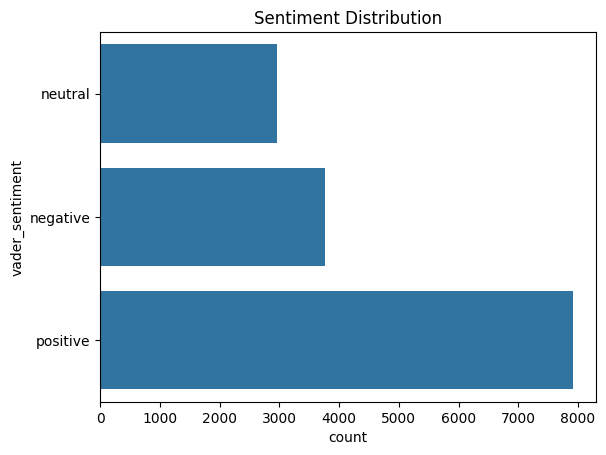

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot sentiment distribution
sns.countplot(df['vader_sentiment'])
plt.title("Sentiment Distribution")
plt.show()

In [7]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Vectorize the text data
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
text_matrix = vectorizer.fit_transform(df['clean_text'])

# Fit LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(text_matrix)

# Display topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Get top 10 words for each topic
no_top_words = 10
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)

Topic 0:
flight usairways americanair cancelled hold hours help southwestair flightled phone
Topic 1:
usairways service united customer americanair southwestair thank thanks bag time
Topic 2:
jetblue southwestair virginamerica thanks love fleek thank guys fleets new
Topic 3:
flight united usairways plane gate delayed jetblue time delay hour
Topic 4:
united americanair southwestair thanks dm im dont service email airline


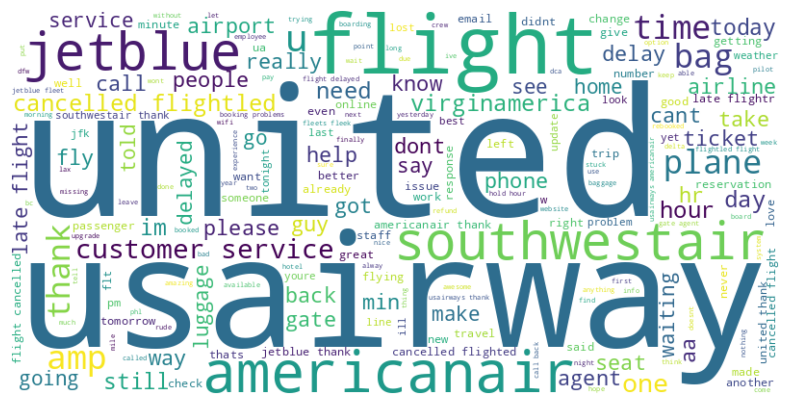

In [8]:
from wordcloud import WordCloud

# Create a word cloud for the clean text
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['clean_text']))

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()